In [30]:
# Importo librerias necesarias
import warnings
warnings.filterwarnings("ignore")
import numpy as np # librería para poder usar arreglos
import pandas as pd # librería para poder usad DataFrames (tablas)
import plotly.express as px
import matplotlib.pyplot as plt # to plot
import seaborn as sns # to plot
import sklearn # librería para poder usar modelos de machine learning
import os
import urllib.request
import json

In [31]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.decomposition as sk # to compute PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression


In [32]:
def get_data():
    """
    Funcion para obtener los datos del archivo covid.csv
    """

    dataSet = pd.read_csv("covid.csv", header=0)
    dataSet.set_index('date', inplace=True)
    dataSet.index = pd.to_datetime(dataSet.index,format='%d/%m/%y',errors='ignore')

    return dataSet

def infoData(dataSet):
    """
    Funcion para obtener datos generales
    """

    print(dataSet.head(10))
    print("")
    print(dataSet.info())
    print("")
    print(dataSet.isnull().sum())
    print("")

In [33]:
data = get_data()
infoData(data)


            AGUASCALIENTES  BAJA CALIFORNIA  BAJA CALIFORNIA SUR  CAMPECHE  \
date                                                                         
2020-02-26               0                0                    0         0   
2020-02-27               0                0                    0         0   
2020-02-28               0                0                    0         0   
2020-02-29               0                0                    0         0   
2020-03-01               0                0                    0         0   
2020-03-02               0                0                    0         0   
2020-03-03               0                0                    0         0   
2020-03-04               0                0                    0         0   
2020-03-05               0                0                    0         0   
2020-03-06               0                0                    0         0   

            CHIAPAS  CHIHUAHUA  DISTRITO FEDERAL  COAHUILA  COL

In [34]:
#def map(dataSet):
#    """
#    Funcion para visualizar la evolución de casos de Covid-19 en los estados de México usando un mapa de calor interactivo con plotly.
#    """
#
#
    # Asegurarse de que el índice es de tipo fecha y resetearlo para tenerlo como columna
#    df = dataSet.copy()
 #   df = df.reset_index()
#    df.rename(columns={'date': 'Fecha'}, inplace=True)

    # Lista de estados (todas las columnas excepto 'Fecha' y 'Nacional')
#    estados = [col for col in df.columns if col not in ['Fecha', 'Nacional']]

    # Convertir el dataframe a formato largo para plotly
 #   df_long = df.melt(id_vars=['Fecha'], value_vars=estados, var_name='Estado', value_name='Casos')

    # Cargar geojson de México (estados)
    # Puedes descargar un geojson de los estados de México, por ejemplo desde: https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json
    # Aquí se asume que el archivo se llama 'mexico_estados.geojson' y está en el mismo directorio
  #  with open('mexico_estados.geojson', 'r', encoding='utf-8') as f:
   #     mexico_geojson = json.load(f)

    # Crear el mapa animado
    #fig = px.choropleth(
     #   df_long,
      #  geojson=mexico_geojson,
       # locations='Estado',
        #color='Casos',
     #   animation_frame='Fecha',
#        featureidkey='properties.NOM_ENT',  # Depende del geojson, puede ser 'properties.NOM_ENT' o 'properties.name'
 #       color_continuous_scale='Reds',
  #      scope='world',
   #     labels={'Casos': 'Casos normalizados'},
    #    title='Evolución de casos de Covid-19 por estado en México'
    #)
    #fig.update_geos(fitbounds="locations", visible=False)
    #fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    #fig.show()

In [35]:
# %pip show nbformat

In [36]:
#Running `%pip install nbformat` in a Jupyter notebook should install the `nbformat` package. However, if you still see the error `ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed`, possible reasons include:

#1. **Kernel Restart Needed:** After installing a new package, you often need to restart the Jupyter kernel for the changes to take effect.
#2. **Multiple Python Environments:** The notebook kernel might be using a different Python environment than the one where `nbformat` was installed.
#3. **Installation Failed:** The installation may have failed silently or with a warning.

#**How to fix:**
#- Run `%pip show nbformat` in a cell to check if it is installed and its version.
#- If not installed, run `%pip install nbformat --upgrade` and then restart the kernel.
#- Make sure your notebook is running in the same environment where you installed `nbformat`.

#If the problem persists, check your Jupyter server logs for more details.
#map(data)

In [37]:
def preprocess_data(dataSet):
    """
    Funcion para el preprocesamiento de datos
    """

    local_dataSet = dataSet.dropna()
    columns_list = dataSet.columns.tolist()
    min_max_scaler = preprocessing.MinMaxScaler() # standardScaler
    min_max_scaler.fit(local_dataSet)
    new_dataSet = min_max_scaler.transform(local_dataSet)

    new_dataSet = pd.DataFrame(np.round(new_dataSet,4), columns=columns_list)
    new_dataSet.index = local_dataSet.index

    return new_dataSet

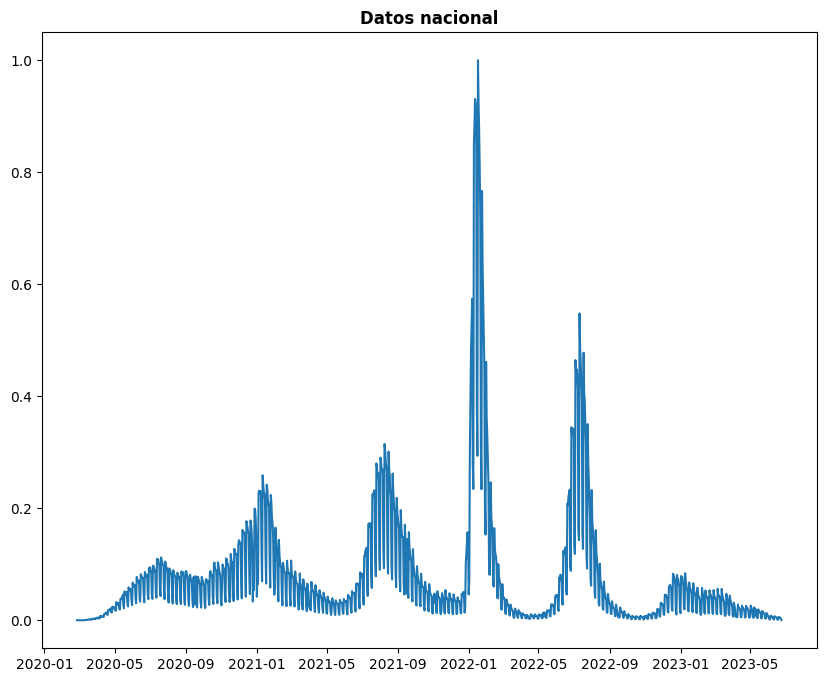

In [38]:
preprocessData = preprocess_data(data)

plt.figure(figsize=(10, 8))
plt.plot(preprocessData['Nacional'])
plt.title('Datos nacional', fontweight='bold')
plt.show()

In [39]:
def pca_Transformation(dataSet):
    features = dataSet
    features = features.drop(['Nacional'], axis=1)

    # principal components analysis
    pca = sk.PCA(n_components=3)
    principalComponents = pca.fit_transform(features)
    principalComp = pd.DataFrame(data = principalComponents,
                                 columns = ['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3'])
    principalComp.set_index(dataSet.index,inplace = True, drop=True)
    principalComp['Nacional'] = dataSet['Nacional']
    cols = principalComp.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    principalComp = principalComp[cols]

    print("==========================================================")
    print("                 PCA ANALYSIS")
    print("----------------------------------------------------------")
    print(principalComp)
    print("\n")

    varRatio = (pca.explained_variance_ratio_)*100
    data = {'P. Comp. 1':varRatio[0],'P. Comp. 2':varRatio[1],'P. Comp. 3':varRatio[2]}
    dfVar = pd.DataFrame(data, index=['Exp Var Ratio %'])
    print(dfVar)
    print("\n")

    return principalComp

In [40]:
pcaData = pca_Transformation(preprocessData)
pcaData.head(1215)

                 PCA ANALYSIS
----------------------------------------------------------
            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2023-06-20    0.0055   -0.385418   -0.023980   -0.031617
2023-06-21    0.0050   -0.389817   -0.025970   -0.026036
2023-06-22    0.0048   -0.394643   -0.029628   -0.022447
2023-06-23    0.0026   -0.401546   -0.021571   -0.028535
2023-06-24    0.0002   -0.419864   -0.024882   -0.014331

[1215 rows x 4 columns]


                 P. Comp. 1  P. Comp. 2  P. Comp. 3
Exp Var Ratio %   81.101835    5.824434    3.614026




,Nacional,P. Comp. 1,P. Comp. 2,P. Comp. 3
date,,,,
2020-02-26,0.0000,-0.420984,-0.025472,-0.013954
2020-02-27,0.0000,-0.420786,-0.025421,-0.013903
2020-02-28,0.0000,-0.420896,-0.025544,-0.013894
2020-02-29,0.0000,-0.420792,-0.025320,-0.014072
2020-03-01,0.0000,-0.420784,-0.025356,-0.013891
...,...,...,...,...
2023-06-20,0.0055,-0.385418,-0.023980,-0.031617
2023-06-21,0.0050,-0.389817,-0.025970,-0.026036
2023-06-22,0.0048,-0.394643,-0.029628,-0.022447


In [41]:
train_data, test_data = train_test_split(pcaData, test_size=0.25, shuffle=False) #Ya probé con 20, y 30
print(train_data.head(1215))
print("")
print(len(train_data))
print("")
print(test_data.head(1215))
print("")
print(len(test_data))

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2022-08-20    0.0210   -0.287385    0.002451    0.002460
2022-08-21    0.0187   -0.293690    0.000125    0.009103
2022-08-22    0.0691   -0.015549    0.005202    0.060701
2022-08-23    0.0507   -0.102404    0.010890    0.055541
2022-08-24    0.0462   -0.132828    0.019228    0.046232

[911 rows x 4 columns]

911

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2022-08-25    0.0404   -0.171591    0.015264    0.020806
2022-08-26    0.0362   -0.204175    0.005791    0.015538
2

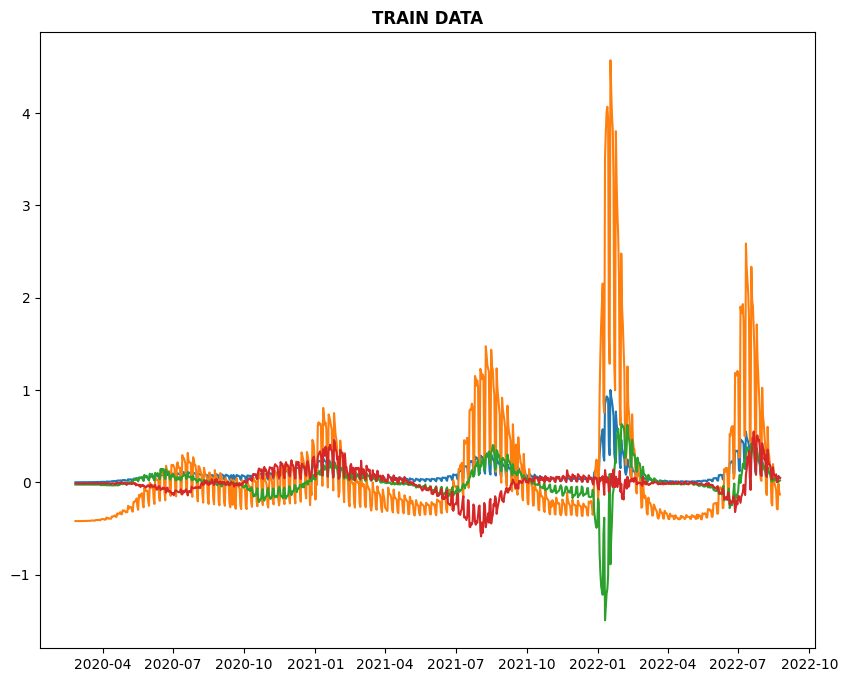

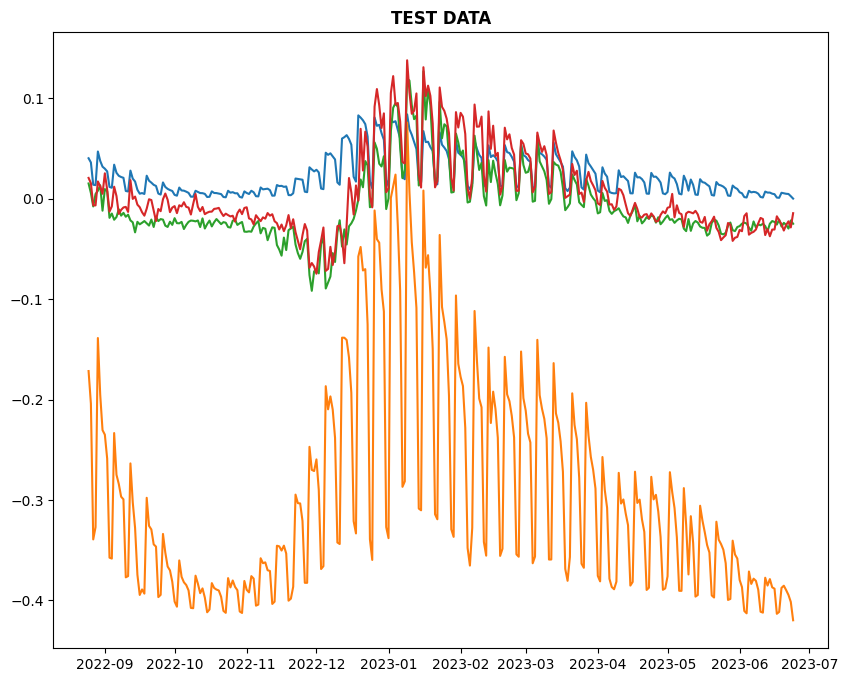

In [42]:
plt.figure(figsize=(10, 8))
plt.plot(train_data)
plt.title('TRAIN DATA', fontweight='bold')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(test_data)
plt.title('TEST DATA', fontweight='bold')
plt.show()

Modelado del PCA

In [43]:
# === Definición de variables (X e Y) Train y Test===
X_train = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]  # Características
Y_train = train_data[['Nacional']]  # Objetivo
X_test = test_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]  # Características
Y_test = test_data[['Nacional']]  # Objetivo

# Definición de variables globales (todos los modelos usan el mismo) para evaluación para Train y Test
n_train = len(Y_train["Nacional"])
print("Número de observaciones (n):", n_train)
p_train = len(X_train.columns)  # Número de variables independientes (componentes principales)
print("Número de variables independientes (p):", p_train)
n_test = len(Y_train["Nacional"])
print("Número de observaciones (n):", n_test)
p_test = len(X_train.columns)  # Número de variables independientes (componentes principales)
print("Número de variables independientes (p):", p_test)

Número de observaciones (n): 911
Número de variables independientes (p): 3
Número de observaciones (n): 911
Número de variables independientes (p): 3


In [44]:
# Decision Tree Regressor
dt_regr = DecisionTreeRegressor()
param_search_dt_regr = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [3, 5, 7, 9, 15, 20, None]
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

grid_search_dt = GridSearchCV(estimator=dt_regr, param_grid=param_search_dt_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_dt.fit(X, y)  # Entreno el modelo con los componentes principales como característica y la columna 'Nacional' como objetivo
best_params_dt = grid_search_dt.best_params_

print("==========================================================")
print("Mejores parámetros para Decision Tree Regressor:")
print(best_params_dt)
print("----------------------------------------------------------")

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Mejores parámetros para Decision Tree Regressor:
{'criterion': 'absolute_error', 'max_depth': 15}
----------------------------------------------------------


In [45]:
dt_optimo = grid_search_dt.best_estimator_
dt_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_dt = dt_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_dt = dt_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_dt = pd.DataFrame(train_pred_dt, columns=["Nacional"], index=X_train.index)
pred_test_df_dt = pd.DataFrame(test_pred_dt, columns=["Nacional"], index=X_test.index)

pred_train_df_dt.columns = ["Nacional"]
pred_test_df_dt.columns = ["Nacional"]


# Datos de mi arbol de decisión
n_leaves_dt = dt_optimo.tree_.n_leaves
n_nodes_dt = dt_optimo.tree_.node_count

print(f"Número de hojas (leaves): {n_leaves_dt}")
print(f"Número total de nodos: {n_nodes_dt}")
print(f"Profundidad del árbol: {dt_optimo.get_depth()}")

Número de hojas (leaves): 844
Número total de nodos: 1687
Profundidad del árbol: 15


In [46]:
def evaluacion_metricas(n_train, pred_df):
    # Initialize metrics dictionary
    metrics_dict = {}
    
    # Calculate basic error metrics
    mse = mean_squared_error(n_train, pred_df["Nacional"])
    mae = mean_absolute_error(n_train, pred_df["Nacional"])
    mape = mean_absolute_percentage_error(n_train, pred_df["Nacional"])
    r2 = r2_score(n_train, pred_df["Nacional"])
    rmse = mse ** 0.5
    
    # Diccionario para almacenar las métricas
    metrics_dict["Nacional"] = {
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,
        "RMSE": rmse,
    }
    
    return pd.DataFrame(metrics_dict).T

train_metrics_dt = evaluacion_metricas(train_data[["Nacional"]], pred_train_df_dt)
test_metrics_dt = evaluacion_metricas(test_data[["Nacional"]], pred_test_df_dt)

print("\n Métrica - Train Nacional:")
print(train_metrics_dt)
print("\n Métrica - Test Nacional:")
print(test_metrics_dt)


 Métrica - Train Nacional:
                   MSE       MAE    MAPE        R2      RMSE
Nacional  5.106476e-08  0.000029  0.0006  0.999997  0.000226

 Métrica - Test Nacional:
               MSE       MAE      MAPE        R2      RMSE
Nacional  0.000027  0.003288  0.175958  0.934469  0.005244


In [47]:
def evaluacion_metricas(n_train, pred_df, mse):
   
    # Diccionario para almacenar las métricas
    metrics_dict = {}
    
    # obtengo k 
    k_dt = dt_optimo.tree_.node_count - n_leaves_dt # Estimación de k para DT, otorgada por el profesor
    # RESIDUAL SUM OF SQUARES (RSS)
    rss = np.sum((n_train - pred_df["Nacional"]) ** 2)

    # REGRESSION SUM OF SQUARES (SSR)
    ssr = np.sum((pred_df["Nacional"] - np.mean(n_train)) ** 2)

    # TOTAL SUM OF SQUARES (TSS)
    tss = rss + ssr  # Fórmula TSS proporcionada por el profesor

    # Calculo criterios de información si mse es mayor a 0
    if mse > 0:
        
        # AKAIKE INFORMATION CRITERION (AIC)
        aic =   n_train * np.log(rss/n_train) + 2 * k_dt # Fórmula AIC proporcionada por el profesor
        bic = n_train * np.log(rss/n_train) + k_dt * np.log(n_train)  # Fórmula BIC proporcionada por el profesor
    else:
        aic = np.nan
        bic = np.nan
    
    # AMEMIYA’s PREDICTION CRITERION (APC)n
    apc = np.log(rss) + 2/n_train * k_dt  # Fórmula APC proporcionada por el profesor
    
    # Lo agrego al diccionario de métricas
    metrics_dict["Nacional"] = {
        "AIC": aic,
        "APC": apc,
        "BIC": bic,
        "RSS": rss,
        "SSR": ssr,
        "TSS": tss,
    }

    return pd.DataFrame(metrics_dict).T

train_metrics_rf = evaluacion_metricas(
    train_data[["Nacional"]],
    pred_train_df_dt,
    mse=mean_squared_error(train_data[["Nacional"]], pred_train_df_dt["Nacional"])
)
test_metrics_rf = evaluacion_metricas(
    test_data[["Nacional"]],
    pred_test_df_dt,
    mse=mean_squared_error(test_data[["Nacional"]], pred_test_df_dt["Nacional"])
)

print("\n Métrica - Train Nacional:")
print(train_metrics_rf)
print("\n Métrica - Test Nacional:")
print(test_metrics_rf)


 Métrica - Train Nacional:
                                                        AIC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        APC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        BIC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        RSS        SSR  \
Nacional  Nacional               0.0
2020-02-26 00:00:00...  14.865176   

                                                        TSS  
Nacional  Nacional               14.865176
2020-02-26 00...  

 Métrica - Test Nacional:
                                                        AIC  \
Nacional              2022-08-25 00:00:00  2022-08-26 00...   

                                                        APC  \
Nacional              2022-08-25 00:00:00  2022-08-26 00...   

                                     

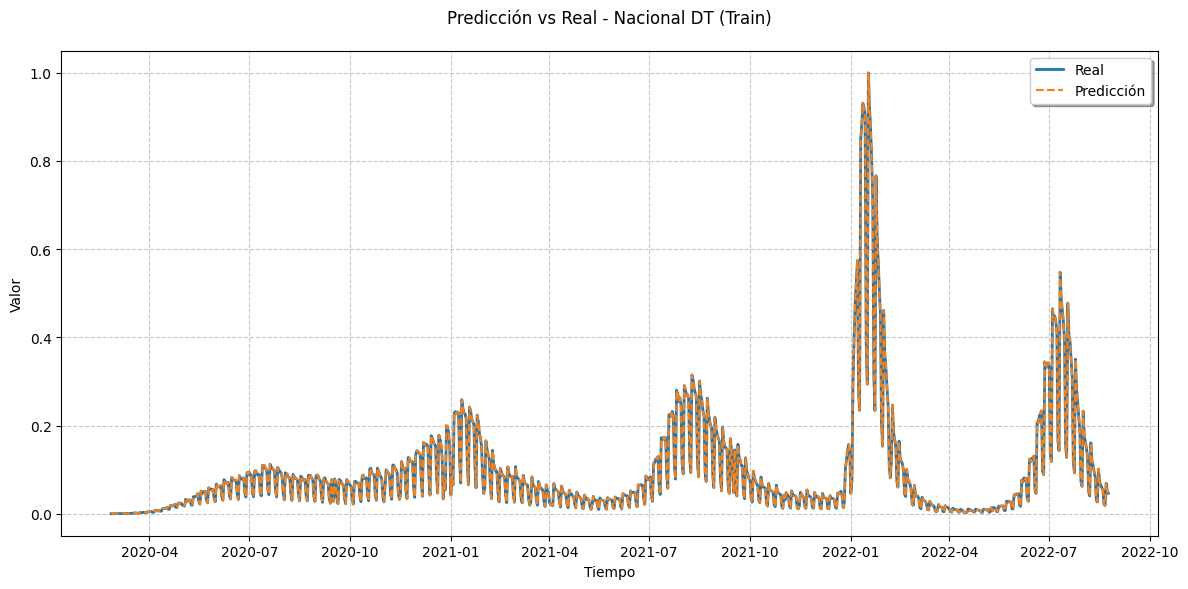

In [48]:
#Grafica de la predicción vs real DT
plt.figure(figsize=(12, 6))  
plt.plot(Y_train.index, Y_train.values, label="Real", linewidth=2)  
plt.plot(pred_train_df_dt.index, pred_train_df_dt.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional DT (Train)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

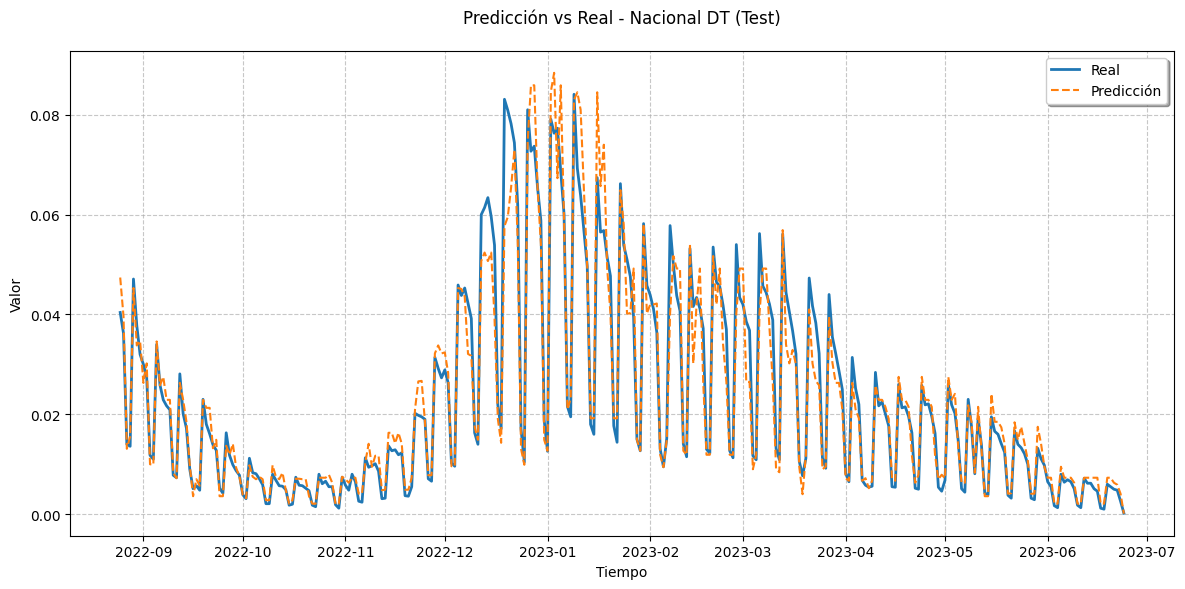

In [49]:
#Grafica de la predicción vs real DT
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_dt.index, pred_test_df_dt.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional DT (Test)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [50]:
# Random forest
rf_regr = RandomForestRegressor()
param_search_rf_regr = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'], #Puedo añadir 'friedman_mse',
    'n_estimators': [10, 50, 100, 200, None], # Puedo probar con [10, 50, 100, 200, 500]
    'max_depth': [3, 5, 7, 9, 15, 20, None]
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

grid_search_rf = GridSearchCV(estimator=rf_regr, param_grid=param_search_rf_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_rf.fit(X, y)  # Entreno el modelo con la columna 'Nacional' como característica y los componentes principales como objetivo
best_params_rf = grid_search_rf.best_params_

print("==========================================================")
print("Mejores parámetros para Decision Tree Regressor:")
print(best_params_rf)
print("----------------------------------------------------------")

Fitting 5 folds for each of 105 candidates, totalling 525 fits
Mejores parámetros para Decision Tree Regressor:
{'criterion': 'squared_error', 'max_depth': 15, 'n_estimators': 10}
----------------------------------------------------------


In [51]:
rf_optimo = grid_search_rf.best_estimator_
# === Ajustar el modelo RF con los datos de entrenamiento ===
rf_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_rf = rf_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_rf = rf_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_rf = pd.DataFrame(train_pred_rf, columns=["Nacional"], index=X_train.index)
pred_test_df_rf = pd.DataFrame(test_pred_rf, columns=["Nacional"], index=X_test.index)

pred_train_df_rf.columns = ["Nacional"]
pred_test_df_rf.columns = ["Nacional"]

# Calcular estadísticas de los árboles individuales en el Random Forest
n_leaves_rf = [est.tree_.n_leaves for est in rf_optimo.estimators_]
n_nodes_rf = [est.tree_.node_count for est in rf_optimo.estimators_]
depths_rf = [est.get_depth() for est in rf_optimo.estimators_]

print(f"Número promedio de hojas (leaves): {np.mean(n_leaves_rf):.2f}")
print(f"Número promedio de nodos: {np.mean(n_nodes_rf):.2f}")
print(f"Profundidad promedio del árbol: {np.mean(depths_rf):.2f}")

Número promedio de hojas (leaves): 550.60
Número promedio de nodos: 1100.20
Profundidad promedio del árbol: 15.00


In [52]:
rf_train_results = pd.DataFrame({
    "Real Nacional": train_data["Nacional"],
    "Pred. Nacional": pred_train_df_rf["Nacional"]
})
# Creo un dataframe con los resultados
rf_train_results["Residuals"] = rf_train_results["Real Nacional"] - rf_train_results["Pred. Nacional"]
# Residuos diferencia entre valor real y valor predicho (error del modelo).
rf_train_results["Rel. Error"] = (1 - (rf_train_results["Pred. Nacional"] / rf_train_results["Real Nacional"])).abs()
# Datos de prueba (test)
rf_test_pred = pred_test_df_rf["Nacional"]
rf_test_results = pd.DataFrame({
    "Real Nacional": test_data["Nacional"],
    "Pred. Nacional": rf_test_pred
})
rf_test_results["Residuals"] = rf_test_results["Real Nacional"] - rf_test_results["Pred. Nacional"]
rf_test_results["Rel. Error"] = (1 - (rf_test_results["Pred. Nacional"] / rf_test_results["Real Nacional"])).abs()

In [53]:
def evaluacion_metricas(n_train, pred_df):
    # Initialize metrics dictionary
    metrics_dict = {}
    
    # Calculate basic error metrics
    mse = mean_squared_error(n_train, pred_df["Nacional"])
    mae = mean_absolute_error(n_train, pred_df["Nacional"])
    mape = mean_absolute_percentage_error(n_train, pred_df["Nacional"])
    r2 = r2_score(n_train, pred_df["Nacional"])
    rmse = mse ** 0.5
    
    # Diccionario para almacenar las métricas
    metrics_dict["Nacional"] = {
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,
        "RMSE": rmse,
    }
    
    return pd.DataFrame(metrics_dict).T

train_metrics_rf = evaluacion_metricas(train_data[["Nacional"]], pred_train_df_rf)
test_metrics_rf = evaluacion_metricas(test_data[["Nacional"]], pred_test_df_rf)

print("\n Métrica - Train Nacional:")
print(train_metrics_rf)
print("\n Métrica - Test Nacional:")
print(test_metrics_rf)


 Métrica - Train Nacional:
               MSE       MAE      MAPE        R2      RMSE
Nacional  0.000024  0.002324  0.030239  0.998554  0.004858

 Métrica - Test Nacional:
               MSE       MAE      MAPE        R2      RMSE
Nacional  0.000017  0.002487  0.134605  0.960234  0.004085


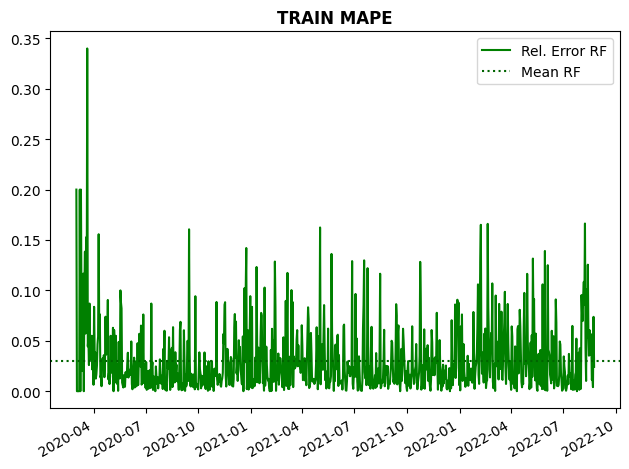

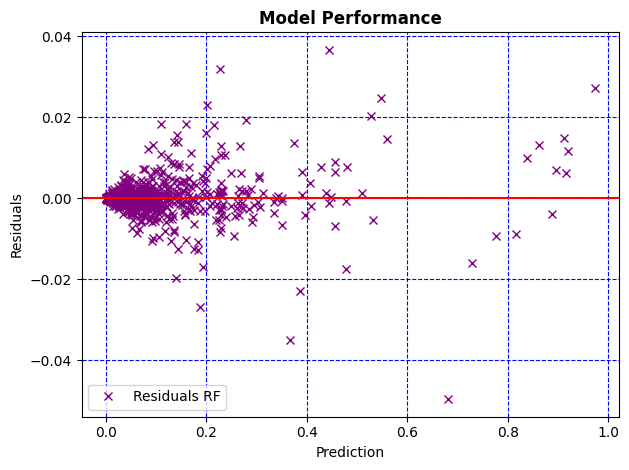

In [54]:
plt.figure()
plt.plot(rf_train_results["Rel. Error"], color="green", label="Rel. Error RF") # Random Forest error
plt.axhline(train_metrics_rf["MAPE"].iloc[0], color='darkgreen', linestyle='dotted', label='Mean RF') # Random Forest MAPE
plt.gcf().autofmt_xdate()
plt.title('TRAIN MAPE', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(rf_train_results['Pred. Nacional'], rf_train_results['Residuals'], 'x', color='purple', label='Residuals RF') #Random Forest 
plt.grid(color='b', linestyle='dashed')
plt.axhline(y=0, color='red')
plt.title("Model Performance", fontweight='bold')
plt.xlabel('Prediction')
plt.ylabel('Residuals')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [55]:
def evaluacion_metricas(n_train, pred_df, mse):
   
    # Diccionario para almacenar las métricas
    metrics_dict = {}
    
    # obtengo k 
    k_rf = sum([nodes - leaves for nodes, leaves in zip(n_nodes_rf, n_leaves_rf)]) # Estimación de k para Rf, adaptada a la que el profesor mencionó
    
    # RESIDUAL SUM OF SQUARES (RSS)
    rss = np.sum((n_train - pred_df["Nacional"]) ** 2)

    # REGRESSION SUM OF SQUARES (SSR)
    ssr = np.sum((pred_df["Nacional"] - np.mean(n_train)) ** 2)

    # TOTAL SUM OF SQUARES (TSS)
    tss = rss + ssr  # Fórmula TSS proporcionada por el profesor

    # Calculate information criteria
    if mse > 0:
        
        # AKAIKE INFORMATION CRITERION (AIC)
        aic =   n_train * np.log(rss/n_train) + 2 * k_rf # Fórmula AIC proporcionada por el profesor
        bic = n_train * np.log(rss/n_train) + k_rf * np.log(n_train)  # Fórmula BIC proporcionada por el profesor
    else:
        aic = np.nan
        bic = np.nan
    
    # AMEMIYA’s PREDICTION CRITERION (APC)n
    apc = np.log(rss) + 2/n_train * k_rf  # Fórmula APC proporcionada por el profesor
    
    # Store all metrics in dictionary
    metrics_dict["Nacional"] = {
        "AIC": aic,
        "APC": apc,
        "BIC": bic,
        "RSS": rss,
        "SSR": ssr,
        "TSS": tss,
    }

    return pd.DataFrame(metrics_dict).T

train_metrics_rf = evaluacion_metricas(
    train_data[["Nacional"]],
    pred_train_df_rf,
    mse=mean_squared_error(train_data[["Nacional"]], pred_train_df_rf["Nacional"])
)
test_metrics_rf = evaluacion_metricas(
    test_data[["Nacional"]],
    pred_test_df_rf,
    mse=mean_squared_error(test_data[["Nacional"]], pred_test_df_rf["Nacional"])
)

print("\n Métrica - Train Nacional:")
print(train_metrics_rf)
print("\n Métrica - Test Nacional:")
print(test_metrics_rf)


 Métrica - Train Nacional:
                                                        AIC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        APC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        BIC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        RSS        SSR  \
Nacional  Nacional               0.0
2020-02-26 00:00:00...  14.719941   

                                                        TSS  
Nacional  Nacional               14.719941
2020-02-26 00...  

 Métrica - Test Nacional:
                                                        AIC  \
Nacional              2022-08-25 00:00:00  2022-08-26 00...   

                                                        APC  \
Nacional              2022-08-25 00:00:00  2022-08-26 00...   

                                     

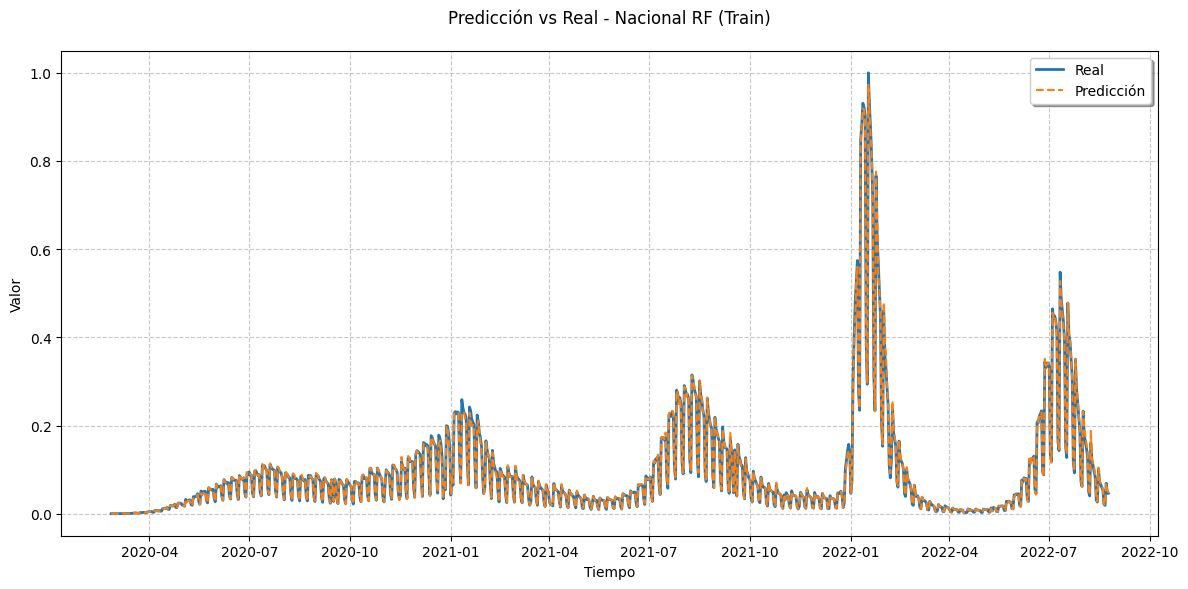

In [56]:
#Grafica de la predicción vs real RF Train
plt.figure(figsize=(12, 6))  
plt.plot(Y_train.index, Y_train.values, label="Real", linewidth=2)  
plt.plot(pred_train_df_rf.index, pred_train_df_rf.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional RF (Train)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

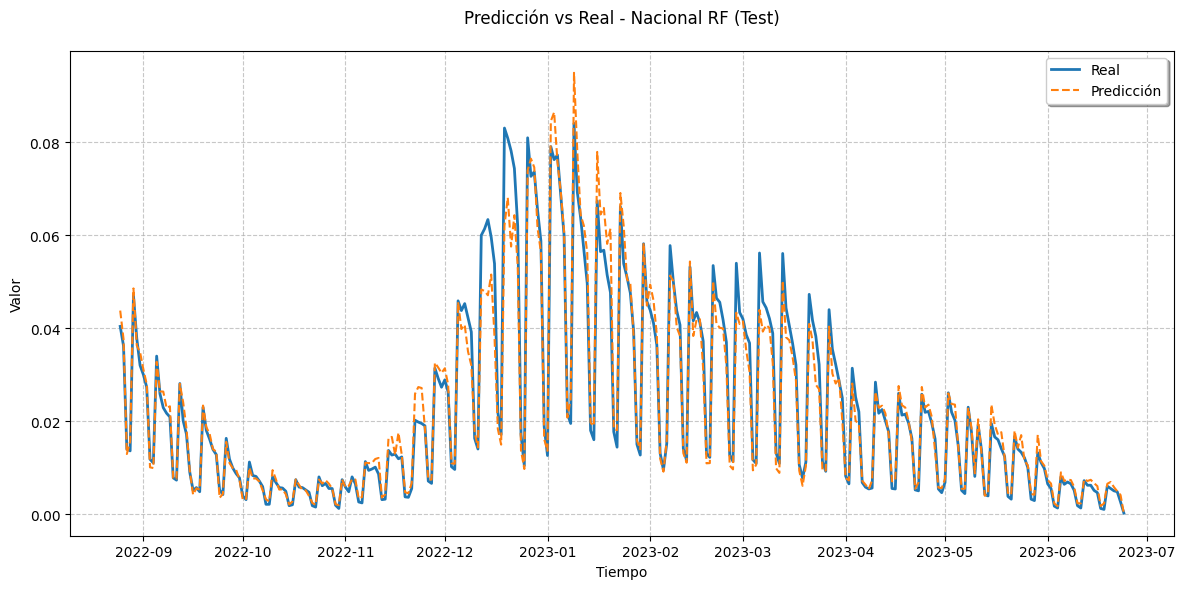

In [57]:
#Grafica de la predicción vs real RF Test
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_rf.index, pred_test_df_rf.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional RF (Test)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [66]:
# Support Vector Machine
svm_regr = svm.SVR()
param_search_svm_regr = {
    'kernel': ['rbf', 'poly', 'sigmoid'],# , 'poly', 'rbf', 'sigmoid' linear
    'degree': [2, 3, 4, 5],  # 3, 4, 5, 6
    #'C': [0.1, 1, 10], # Puedo probar con [0.001, 0.01, 0.1, 1]
    'gamma': ['scale', 'auto'],
    'epsilon': [0.005, 0.05, 0.1, 0.2, 0.5],
    'max_iter': [-1]     # Número máximo de iteraciones
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y Y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

grid_search_svm = GridSearchCV(estimator=svm_regr, param_grid=param_search_svm_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_svm.fit(X, y)  # Entreno el modelo con los componentes principales como característica y la columna 'Nacional' como objetivo
best_params_svm = grid_search_svm.best_params_

print("==========================================================")
print("Mejores parámetros para Support Vector Machine Regressor:")
print(best_params_svm)
print("----------------------------------------------------------")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Mejores parámetros para Support Vector Machine Regressor:
{'degree': 2, 'epsilon': 0.005, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1}
----------------------------------------------------------


In [67]:
svm_optimo = grid_search_svm.best_estimator_
# === Ajustar el modelo SVM con los datos de entrenamiento ===
svm_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_svm = svm_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_svm = svm_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_svm = pd.DataFrame(train_pred_svm, columns=["Nacional"], index=X_train.index)
pred_test_df_svm = pd.DataFrame(test_pred_svm, columns=["Nacional"], index=X_test.index)

pred_train_df_svm.columns = ["Nacional"]
pred_test_df_svm.columns = ["Nacional"]

In [68]:
def evaluacion_metricas(n_train, pred_df):
    # Initialize metrics dictionary
    metrics_dict = {}
    
    # Calculate basic error metrics
    mse = mean_squared_error(n_train, pred_df["Nacional"])
    mae = mean_absolute_error(n_train, pred_df["Nacional"])
    mape = mean_absolute_percentage_error(n_train, pred_df["Nacional"])
    r2 = r2_score(n_train, pred_df["Nacional"])
    rmse = mse ** 0.5
    
    # Diccionario para almacenar las métricas
    metrics_dict["Nacional"] = {
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,
        "RMSE": rmse,
    }
    
    return pd.DataFrame(metrics_dict).T

# Define pred_test_df_svm before using it
pred_test_df_svm = pd.DataFrame(test_pred_svm, columns=["Nacional"], index=X_test.index)

train_metrics_svm = evaluacion_metricas(train_data[["Nacional"]], pred_train_df_svm)
test_metrics_svm = evaluacion_metricas(test_data[["Nacional"]], pred_test_df_svm)

print("\n Métrica - Train Nacional:")
print(train_metrics_svm)
print("\n Métrica - Test Nacional:")
print(test_metrics_svm)


 Métrica - Train Nacional:
               MSE       MAE          MAPE        R2      RMSE
Nacional  0.000068  0.005299  1.321551e+11  0.995818  0.008261

 Métrica - Test Nacional:
               MSE       MAE      MAPE        R2      RMSE
Nacional  0.000021  0.003766  0.553567  0.948869  0.004632


In [69]:
def evaluacion_metricas(n_train, pred_df, mse):
   
    # Diccionario para almacenar las métricas
    metrics_dict = {}
    
    # obtengo k 
    k_svm = len(svm_optimo.support_vectors_) # Estimación de k para SVM, otorgada por el profesor
    
    # RESIDUAL SUM OF SQUARES (RSS)
    rss = np.sum((n_train - pred_df["Nacional"]) ** 2)

    # REGRESSION SUM OF SQUARES (SSR)
    ssr = np.sum((pred_df["Nacional"] - np.mean(n_train)) ** 2)

    # TOTAL SUM OF SQUARES (TSS)
    tss = rss + ssr  # Fórmula TSS proporcionada por el profesor

    # Calculate information criteria
    if mse > 0:
        
        # AKAIKE INFORMATION CRITERION (AIC)
        aic =   n_train * np.log(rss/n_train) + 2 * k_svm # Fórmula AIC proporcionada por el profesor
        bic = n_train * np.log(rss/n_train) + k_svm * np.log(n_train)  # Fórmula BIC proporcionada por el profesor
    else:
        aic = np.nan
        bic = np.nan
    
    # AMEMIYA’s PREDICTION CRITERION (APC)n
    apc = np.log(rss) + 2/n_train * k_svm  # Fórmula APC proporcionada por el profesor
    
    # Store all metrics in dictionary
    metrics_dict["Nacional"] = {
        "AIC": aic,
        "APC": apc,
        "BIC": bic,
        "RSS": rss,
        "SSR": ssr,
        "TSS": tss,
    }

    return pd.DataFrame(metrics_dict).T

train_metrics_svm = evaluacion_metricas(
    train_data[["Nacional"]],
    pred_train_df_svm,
    mse=mean_squared_error(train_data[["Nacional"]], pred_train_df_svm["Nacional"])
)
test_metrics_svm = evaluacion_metricas(
    test_data[["Nacional"]],
    pred_test_df_svm,
    mse=mean_squared_error(test_data[["Nacional"]], pred_test_df_svm["Nacional"])
)

print("\n Métrica - Train Nacional:")
print(train_metrics_svm)
print("\n Métrica - Test Nacional:")
print(test_metrics_svm)


 Métrica - Train Nacional:
                                                        AIC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        APC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        BIC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        RSS        SSR  \
Nacional  Nacional               0.0
2020-02-26 00:00:00...  14.693198   

                                                        TSS  
Nacional  Nacional               14.693198
2020-02-26 00...  

 Métrica - Test Nacional:
                                                        AIC  \
Nacional              2022-08-25 00:00:00  2022-08-26 00...   

                                                        APC  \
Nacional              2022-08-25 00:00:00  2022-08-26 00...   

                                     

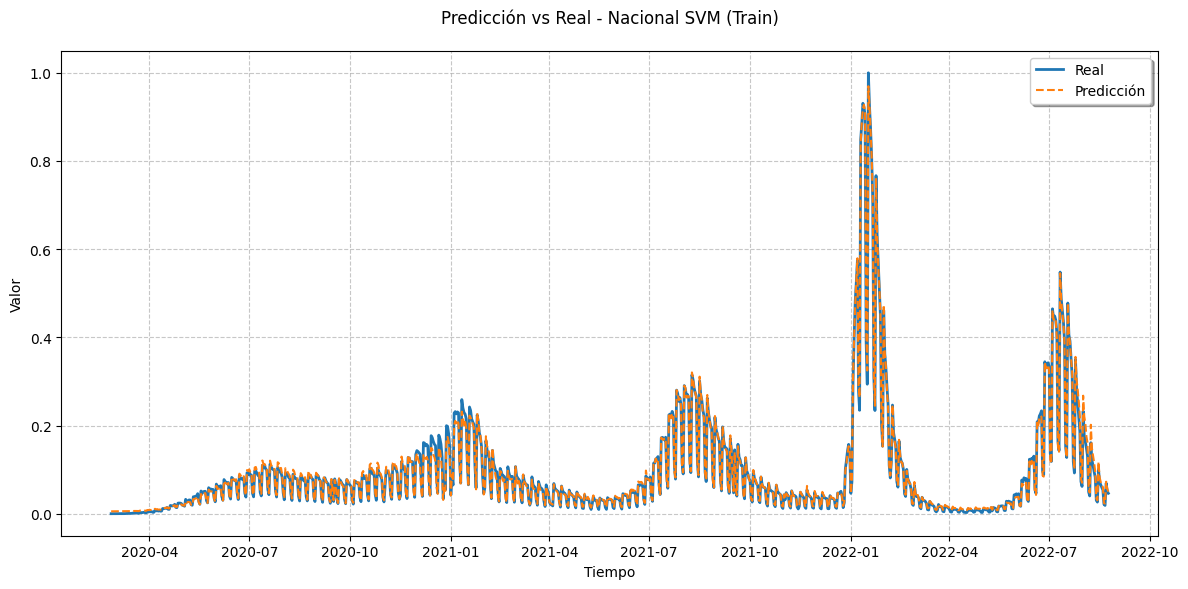

In [70]:
#Grafica de la predicción vs real SVM Train
plt.figure(figsize=(12, 6))  
plt.plot(Y_train.index, Y_train.values, label="Real", linewidth=2)  
plt.plot(pred_train_df_svm.index, pred_train_df_svm.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional SVM (Train)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

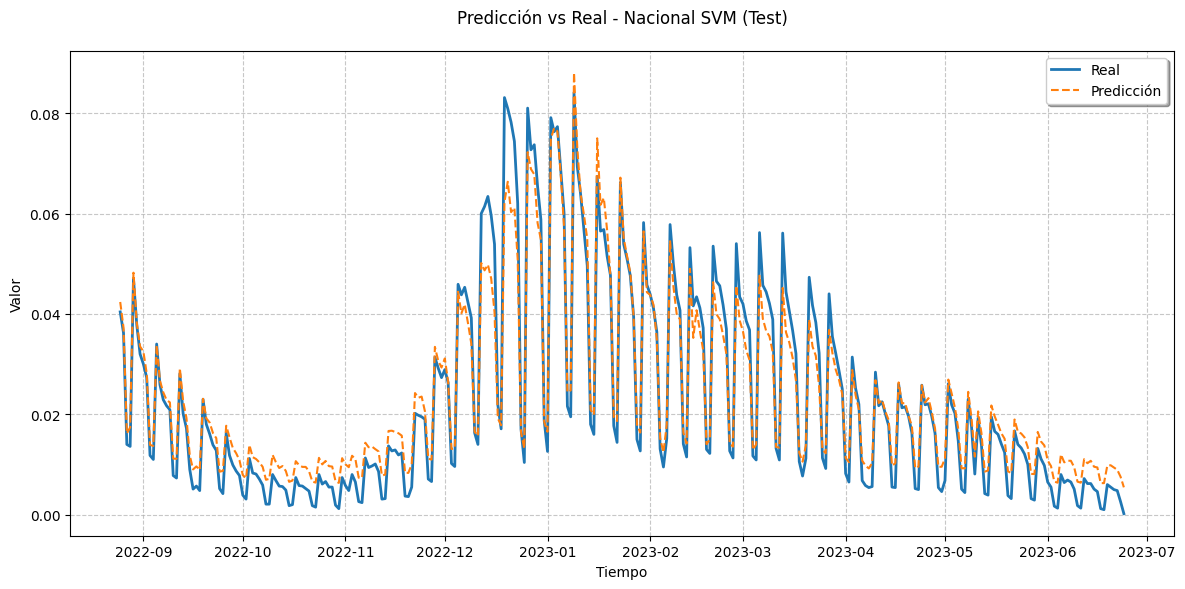

In [71]:
#Grafica de la predicción vs real SVM Test
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_svm.index, pred_test_df_svm.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional SVM (Test)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:

print(pred_test_df_svm.head(10))

            Nacional
date                
2022-08-25  0.091158
2022-08-26  0.088804
2022-08-27  0.090455
2022-08-28  0.090006
2022-08-29  0.093103
2022-08-30  0.089399
2022-08-31  0.087095
2022-09-01  0.088744
2022-09-02  0.087777
2022-09-03  0.091817


In [ ]:
print(Y_test.head(10))

            Nacional
date                
2022-08-25    0.0404
2022-08-26    0.0362
2022-08-27    0.0140
2022-08-28    0.0136
2022-08-29    0.0471
2022-08-30    0.0378
2022-08-31    0.0320
2022-09-01    0.0300
2022-09-02    0.0273
2022-09-03    0.0118


In [ ]:
# X, y = make_regression(n_samples=200, n_features=20, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#               
#'n_samples': [100, 300, 500],# Puedo probar con [100, 200, 300, 400, 500]
# 'n_features': [10, 20, 30],  # 3, 4, 5, 6                                     random_state=1)
#regr = MLPRegressor(random_state=1, max_iter=2000, tol=0.1)
#regr.fit(X_train, y_train)
#MLPRegressor(max_iter=2000, random_state=1, tol=0.1)
#regr.predict(X_test[:2])
#array([  28.98, -291])
#regr.score(X_test, y_test)
#0.98

In [ ]:
# Multi-layer Perceptron Regressor
mlp_regr = MLPRegressor()
param_search_mlp_regr = {
    'random_state': [1, None],  # Fijo el estado aleatorio para reproducibilidad
    'max_iter': [1000, 2000, 3000],  # Puedo probar con [1000, 2000, 3000, 4000]
    'tol': [0.01, 0.1, 0.2],  # Puedo probar con [0.01, 0.05, 0.1, 0.2]
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,)],  # Puedo probar con [(50,), (100,), (150,), (200,), (250,)]
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Puedo probar con ['constant', 'invscaling', 'adaptive']
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]
y = train_data[['Nacional']]

# Le paso este objeto a la funcion de model_template y tambien le paso X Y
grid_search_mlp = GridSearchCV(estimator=mlp_regr, param_grid=param_search_mlp_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_mlp.fit(X, y)  # Entreno el modelo con los componentes principales como característica y la columna 'Nacional' como objetivo
best_params_mlp = grid_search_mlp.best_params_

print("==========================================================")
print("Mejores parámetros para Multi-layer Perceptron Regressor:")
print(best_params_mlp)
print("----------------------------------------------------------")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores parámetros para Multi-layer Perceptron Regressor:
{'hidden_layer_sizes': (200,), 'learning_rate': 'invscaling', 'max_iter': 2000, 'random_state': None, 'tol': 0.1}
----------------------------------------------------------


In [ ]:
mlp_optimo = grid_search_mlp.best_estimator_
# === Ajustar el modelo MLP con los datos de entrenamiento ===
mlp_optimo.fit(X_train, Y_train)

# === Predicciones ===
train_pred_mlp = mlp_optimo.predict(X_train)  # Predecir 'Nacional' para train
test_pred_mlp = mlp_optimo.predict(X_test)    # Predecir 'Nacional' para test

# === Convertir a DataFrames para análisis ===
pred_train_df_mlp = pd.DataFrame(train_pred_mlp, columns=["Nacional"], index=X_train.index)
pred_test_df_mlp = pd.DataFrame(test_pred_mlp, columns=["Nacional"], index=X_test.index)

pred_train_df_mlp.columns = ["Nacional"]
pred_test_df_mlp.columns = ["Nacional"]

# Función para analizar el tamaño de la red neuronal MLP para saber cuando mide su k
def analyze_network_size(mlp_model):
    """
    Analisis del tamaño de una red neuronal MLP y la categoriza en pequeña, mediana o grande.
    """
    # Get network parameters
    n_layers = len(mlp_model.coefs_)
    n_neurons = [layer.shape[0] for layer in mlp_model.coefs_]
    total_params = sum(layer.size for layer in mlp_model.coefs_)
    
    # Size categorization
    if total_params < 1000:
        size_category = "Pequeña"
    elif total_params < 100000:
        size_category = "Mediana"
    else:
        size_category = "Grande"
    
    print(f"Arquitectura de la Red Neuronal:")
    print(f"Número de capas: {n_layers}")
    print(f"Neuronas por capa: {n_neurons}")
    print(f"Total de parámetros: {total_params:,}")
    print(f"Categoría de la red en base a su tamaño: {size_category}")
    
# Use after training your model
analyze_network_size(mlp_optimo)

Arquitectura de la Red Neuronal:
Número de capas: 2
Neuronas por capa: [3, 200]
Total de parámetros: 800
Categoría de la red en base a su tamaño: Pequeña


In [ ]:
def evaluacion_metricas(n_train, pred_df):
    # Initialize metrics dictionary
    metrics_dict = {}
    
    # Calculate basic error metrics
    mse = mean_squared_error(n_train, pred_df["Nacional"])
    mae = mean_absolute_error(n_train, pred_df["Nacional"])
    mape = mean_absolute_percentage_error(n_train, pred_df["Nacional"])
    r2 = r2_score(n_train, pred_df["Nacional"])
    rmse = mse ** 0.5
    
    # Diccionario para almacenar las métricas
    metrics_dict["Nacional"] = {
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,
        "RMSE": rmse,
    }
    
    return pd.DataFrame(metrics_dict).T

pred_test_df_mlp = pd.DataFrame(test_pred_mlp, columns=["Nacional"], index=X_test.index)

train_metrics_mlp = evaluacion_metricas(train_data[["Nacional"]], pred_train_df_mlp)
test_metrics_mlp = evaluacion_metricas(test_data[["Nacional"]], pred_test_df_mlp)

print("\n Métrica - Train Nacional:")
print(train_metrics_mlp)
print("\n Métrica - Test Nacional:")
print(test_metrics_mlp)


 Métrica - Train Nacional:
               MSE       MAE          MAPE        R2      RMSE
Nacional  0.000234  0.010637  2.643311e+11  0.985647  0.015304

 Métrica - Test Nacional:
               MSE       MAE      MAPE        R2      RMSE
Nacional  0.000057  0.006925  1.189058  0.864446  0.007542


In [ ]:
def evaluacion_metricas(n_train, pred_df, mse):
   
    # Diccionario para almacenar las métricas
    metrics_dict = {}
    
    # obtengo k 
    k_mlp = 50  # Red pequeña: k≈50, Red mediana: k≈100–200, Red grande: k>500
    
    # RESIDUAL SUM OF SQUARES (RSS)
    rss = np.sum((n_train - pred_df["Nacional"]) ** 2)

    # REGRESSION SUM OF SQUARES (SSR)
    ssr = np.sum((pred_df["Nacional"] - np.mean(n_train)) ** 2)

    # TOTAL SUM OF SQUARES (TSS)
    tss = rss + ssr  # Fórmula TSS proporcionada por el profesor

    # Calculate information criteria
    if mse > 0:
        
        # AKAIKE INFORMATION CRITERION (AIC)
        aic =   n_train * np.log(rss/n_train) + 2 * k_mlp # Fórmula AIC proporcionada por el profesor
        bic = n_train * np.log(rss/n_train) + k_mlp * np.log(n_train)  # Fórmula BIC proporcionada por el profesor
    else:
        aic = np.nan
        bic = np.nan
    
    # AMEMIYA’s PREDICTION CRITERION (APC)n
    apc = np.log(rss) + 2/n_train * k_mlp  # Fórmula APC proporcionada por el profesor
    
    # Store all metrics in dictionary
    metrics_dict["Nacional"] = {
        "AIC": aic,
        "APC": apc,
        "BIC": bic,
        "RSS": rss,
        "SSR": ssr,
        "TSS": tss,
    }

    return pd.DataFrame(metrics_dict).T

train_metrics_mlp = evaluacion_metricas(
    train_data[["Nacional"]],
    pred_train_df_mlp,
    mse=mean_squared_error(train_data[["Nacional"]], pred_train_df_mlp["Nacional"])
)
test_metrics_svm = evaluacion_metricas(
    test_data[["Nacional"]],
    pred_test_df_mlp,
    mse=mean_squared_error(test_data[["Nacional"]], pred_test_df_mlp["Nacional"])
)

print("\n Métrica - Train Nacional:")
print(train_metrics_mlp)
print("\n Métrica - Test Nacional:")
print(test_metrics_mlp)


 Métrica - Train Nacional:
                                                        AIC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        APC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        BIC  \
Nacional              2020-02-26 00:00:00  2020-02-27 00...   

                                                        RSS        SSR  \
Nacional  Nacional               0.0
2020-02-26 00:00:00...  12.936537   

                                                        TSS  
Nacional  Nacional               12.936537
2020-02-26 00...  

 Métrica - Test Nacional:
               MSE       MAE      MAPE        R2      RMSE
Nacional  0.000057  0.006925  1.189058  0.864446  0.007542


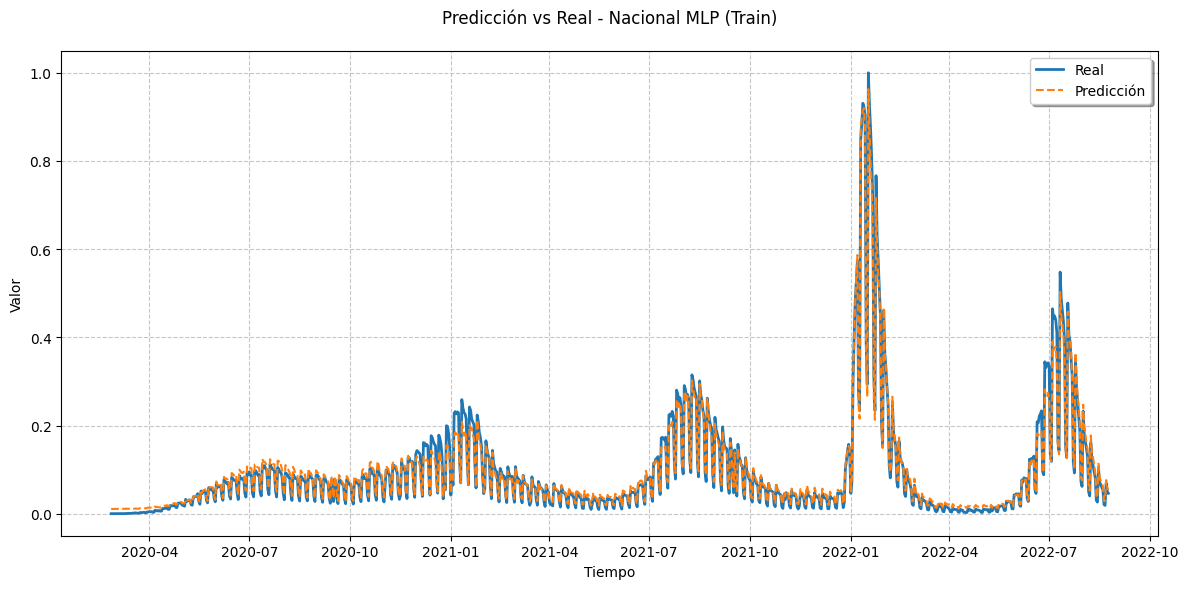

In [ ]:
#Grafica de la predicción vs real MLP Train
plt.figure(figsize=(12, 6))  
plt.plot(Y_train.index, Y_train.values, label="Real", linewidth=2)  
plt.plot(pred_train_df_mlp.index, pred_train_df_mlp.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional MLP (Train)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

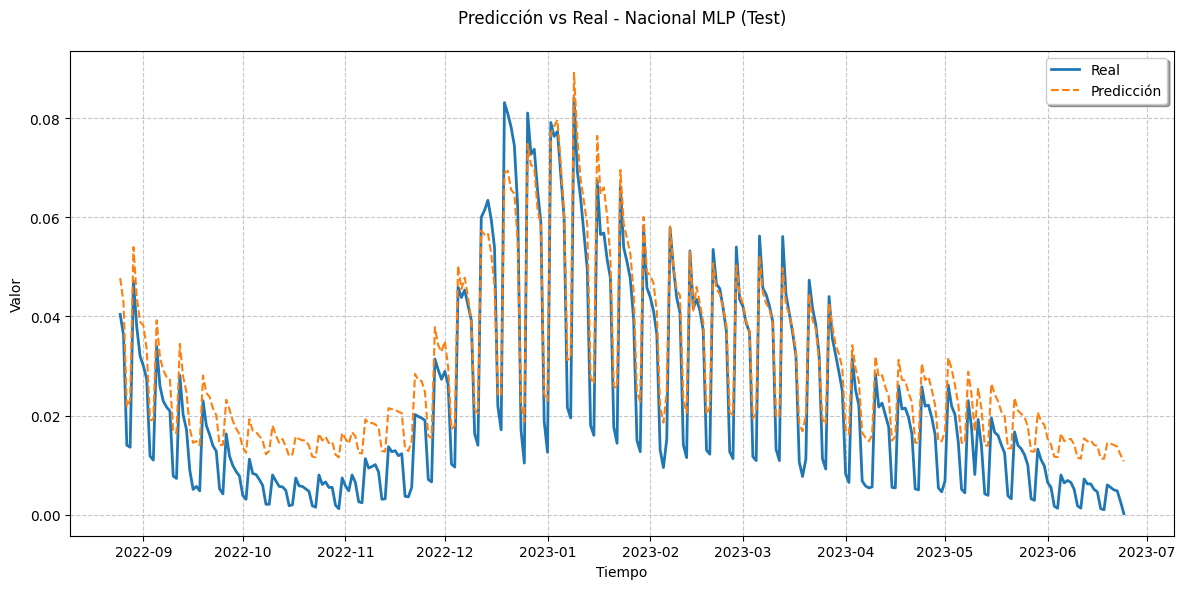

In [ ]:
#Grafica de la predicción vs real MLP Test
plt.figure(figsize=(12, 6))  
plt.plot(Y_test.index, Y_test.values, label="Real", linewidth=2)  
plt.plot(pred_test_df_mlp.index, pred_test_df_mlp.values, label="Predicción", linestyle="--")  
plt.title("Predicción vs Real - Nacional MLP (Test)", fontsize=12, pad=20)
plt.xlabel("Tiempo", fontsize=10)
plt.ylabel("Valor", fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
"""
    Calculate various regression metrics comparing true and predicted values.
    
    Parameters:
    -----------
    true_df : pandas.DataFrame
        DataFrame containing actual values with 'Nacional' column
    pred_df : pandas.DataFrame
        DataFrame containing predicted values with 'Nacional' column
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing calculated metrics
    """

"\n    Calculate various regression metrics comparing true and predicted values.\n\n    Parameters:\n    -----------\n    true_df : pandas.DataFrame\n        DataFrame containing actual values with 'Nacional' column\n    pred_df : pandas.DataFrame\n        DataFrame containing predicted values with 'Nacional' column\n\n    Returns:\n    --------\n    pandas.DataFrame\n        DataFrame containing calculated metrics\n    "